# pix2pixとU-Netの比較
2つのモデルが出力する画像を比較する。

## 前準備
### 主要パッケージのインポート

In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from IPython.display import display
from logging import basicConfig, getLogger, INFO
basicConfig(level=INFO, format='%(asctime)s %(levelname)s :%(message)s')
logger = getLogger(__name__)

### データディレクトリの指定

In [2]:
DATA_ROOT = pathlib.Path('Data/Images/chest_xray')
INPUT_IMAGE_DIR = 'bone_enhancement'
TRUTH_IMAGE_DIR = 'bone_suppression'
CLASS_LABELS = ('lung')
IMAGE_EXT = '.png'

### 画像ファイルを基にpd.DataFrameを作成する

In [3]:
def create_dataset_df(data_root, input_dir, truth_dir, image_ext):
    dfs = []
    root = pathlib.Path(data_root)
    image_filenames = (root / pathlib.Path(input_dir)).glob('*' + image_ext)
    df = pd.DataFrame(image_filenames, columns=['input_path'])
    df['truth_path'] = df['input_path'].map(
        lambda p: root / pathlib.Path(truth_dir) / p.name)
    return df


df_dataset = create_dataset_df(DATA_ROOT, INPUT_IMAGE_DIR, TRUTH_IMAGE_DIR,
                               IMAGE_EXT)
display(df_dataset.head())

input_path  \
0  Data\Images\chest_xray\bone_enhancement\000.png   
1  Data\Images\chest_xray\bone_enhancement\001.png   
2  Data\Images\chest_xray\bone_enhancement\002.png   
3  Data\Images\chest_xray\bone_enhancement\003.png   
4  Data\Images\chest_xray\bone_enhancement\004.png   

                                        truth_path  
0  Data\Images\chest_xray\bone_suppression\000.png  
1  Data\Images\chest_xray\bone_suppression\001.png  
2  Data\Images\chest_xray\bone_suppression\002.png  
3  Data\Images\chest_xray\bone_suppression\003.png  
4  Data\Images\chest_xray\bone_suppression\004.png

### ホールドアウトされたデータの取り出し

In [4]:
from sklearn.model_selection import KFold
N_SPLITS = 5
SEED = 0
kfold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
train_index, test_index = next(kfold.split(df_dataset['input_path']))

df_train = df_dataset.iloc[train_index]
df_test = df_dataset.iloc[test_index]

In [5]:
import tensorflow as tf
import tqdm

INPUT_SHAPE = [256, 256, 1]
IMG_SHAPE = INPUT_SHAPE
N_COMPARE = 10


def load_img(filepath):
    return np.atleast_3d(
        tf.keras.preprocessing.image.load_img(filepath,
                                              color_mode='grayscale',
                                              target_size=IMG_SHAPE))


def load_dataset(df):
    dataset = tf.data.Dataset.from_tensor_slices((
        np.stack(
            [load_img(filepath) for filepath in tqdm.tqdm(df['input_path'])]),
        np.stack(
            [load_img(filepath) for filepath in tqdm.tqdm(df['truth_path'])]),
    ))
    return dataset


def convert(image, truth):
    image = tf.image.convert_image_dtype(image, tf.float32)
    truth = tf.image.convert_image_dtype(truth, tf.float32)
    return image, truth


test_dataset = load_dataset(df_test)
print(test_dataset.element_spec)

100%|██████████| 57/57 [00:00<00:00, 280.62it/s]


(TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))


## pix2pix

In [6]:
generator = tf.keras.models.load_model('pix2pix_generator.h5')

2020-06-16 11:27:29,912 WARNING :No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [7]:
batch = next(
    iter(test_dataset.map(convert).batch(N_COMPARE, drop_remainder=True)))
pix2pix_prediction = generator(batch)
pix2pix_prediction = pix2pix_prediction.numpy()

## U-Net

In [8]:
generator = tf.keras.models.load_model('unet_generator.h5')

In [9]:
unet_prediction = generator.predict(batch)
unet_prediction = unet_prediction

## 比較

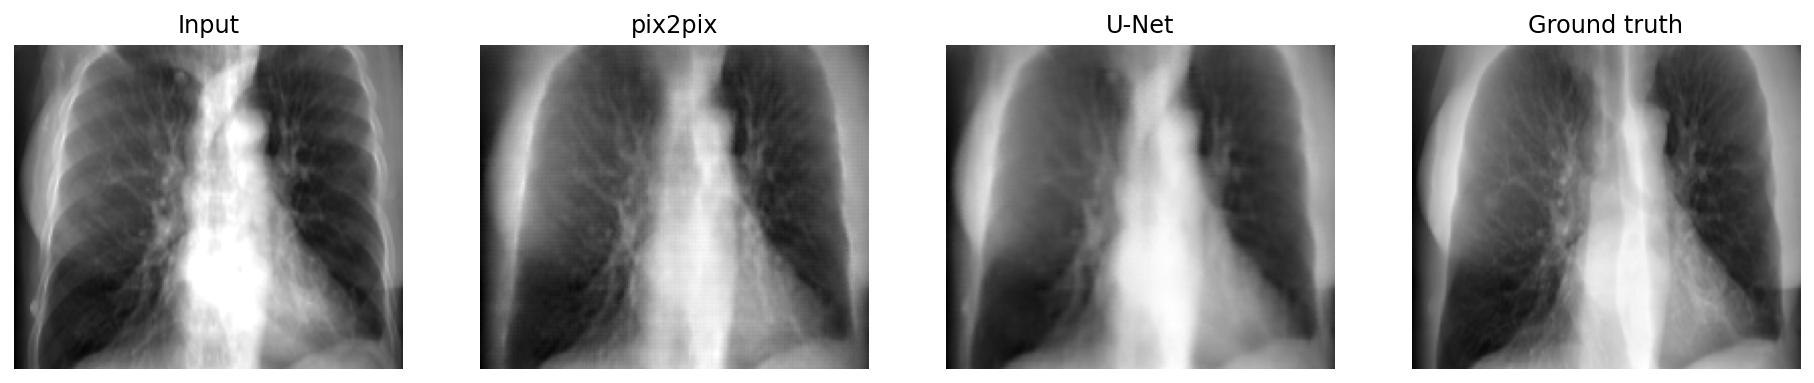

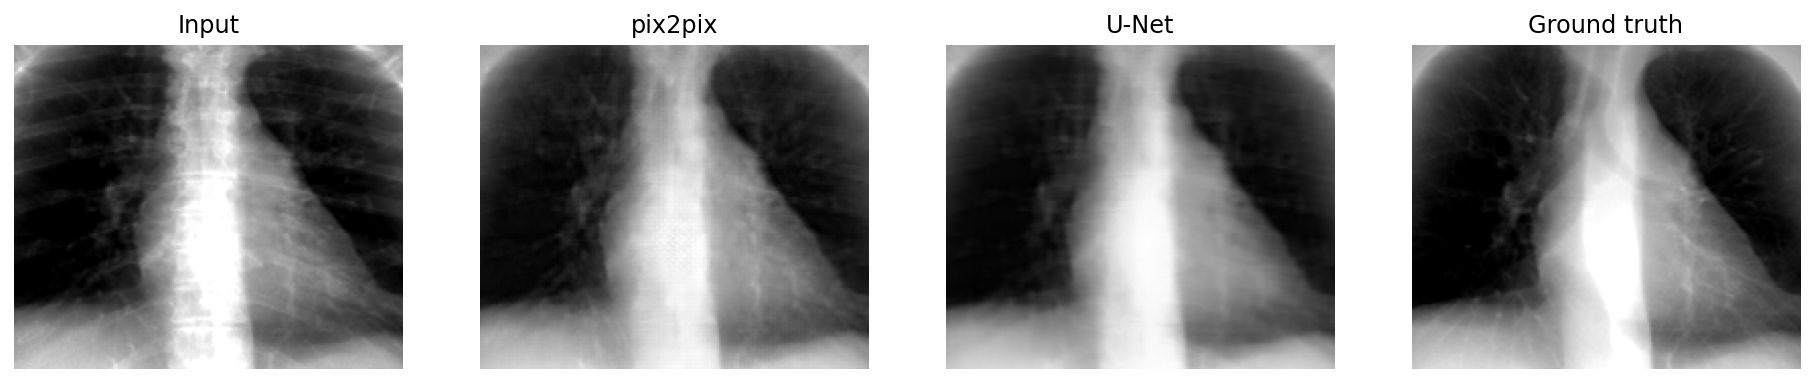

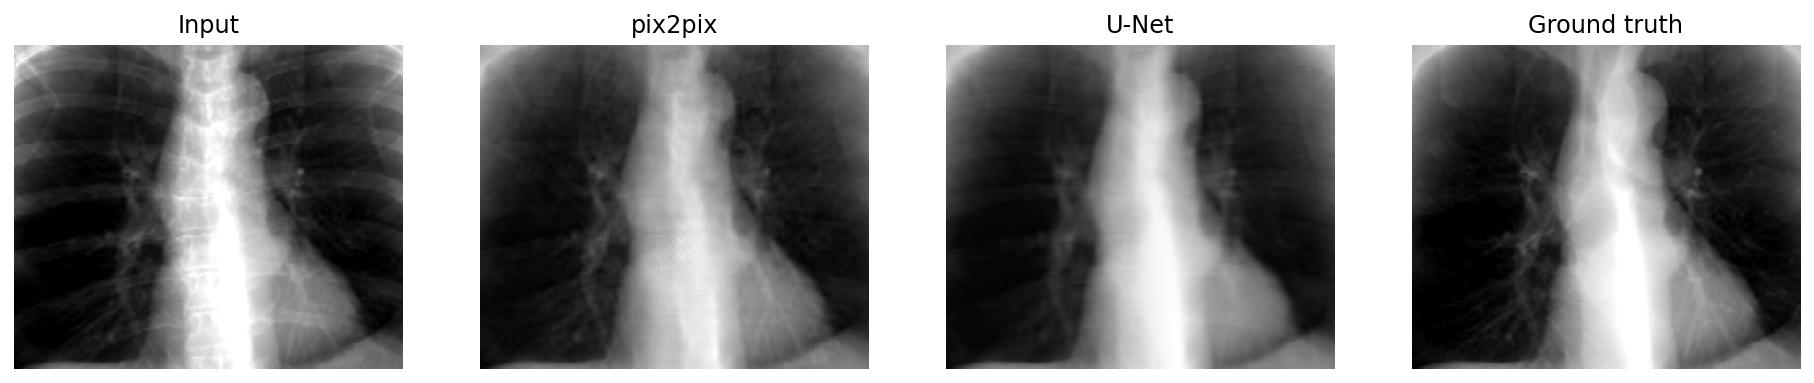

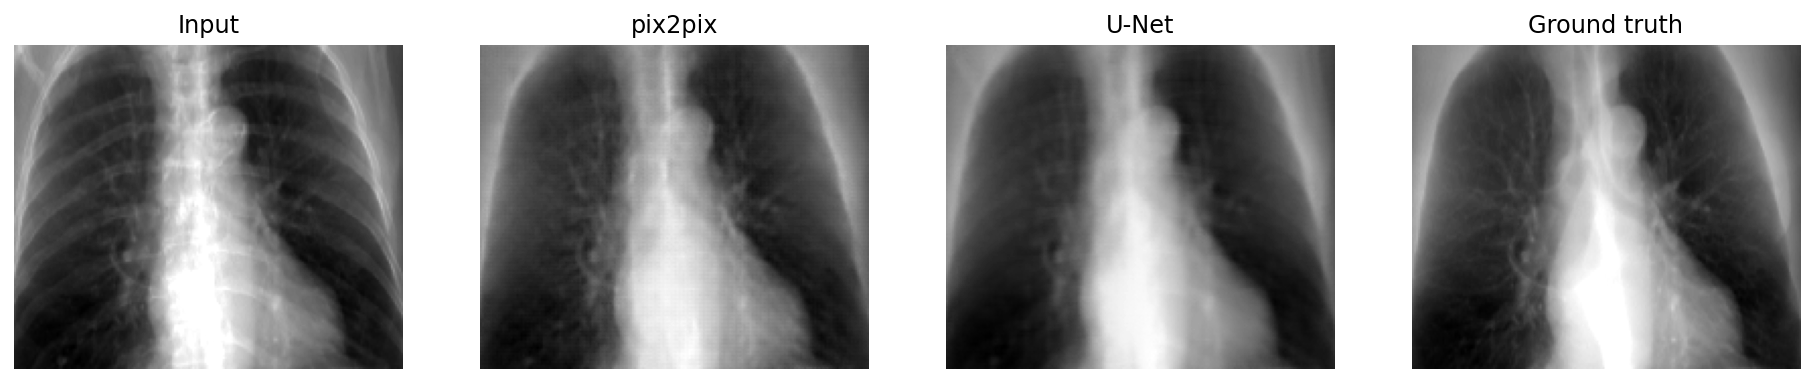

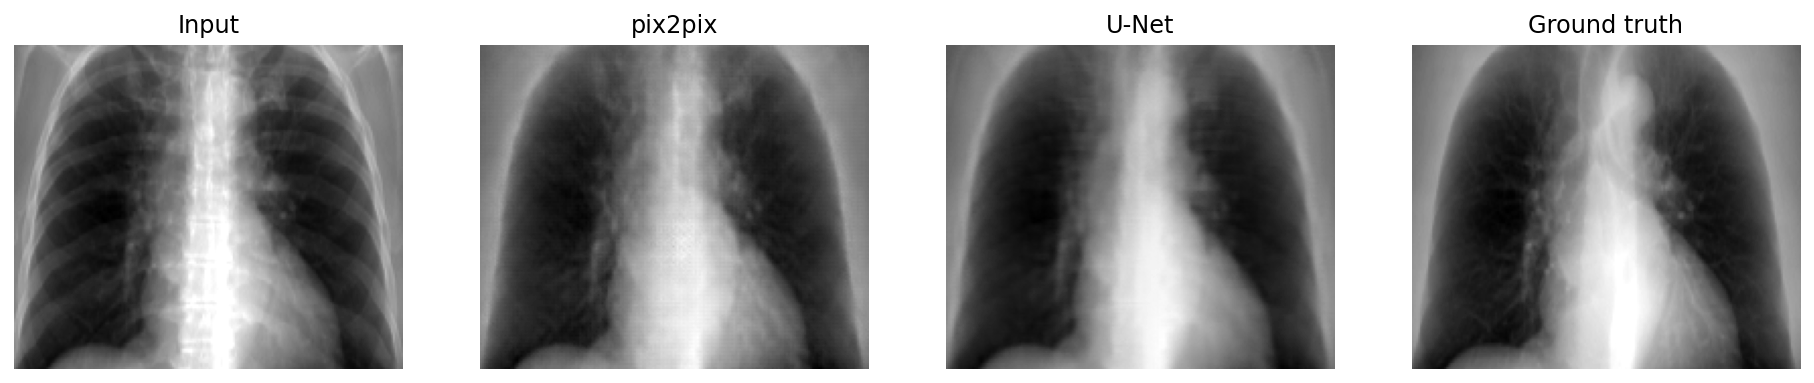

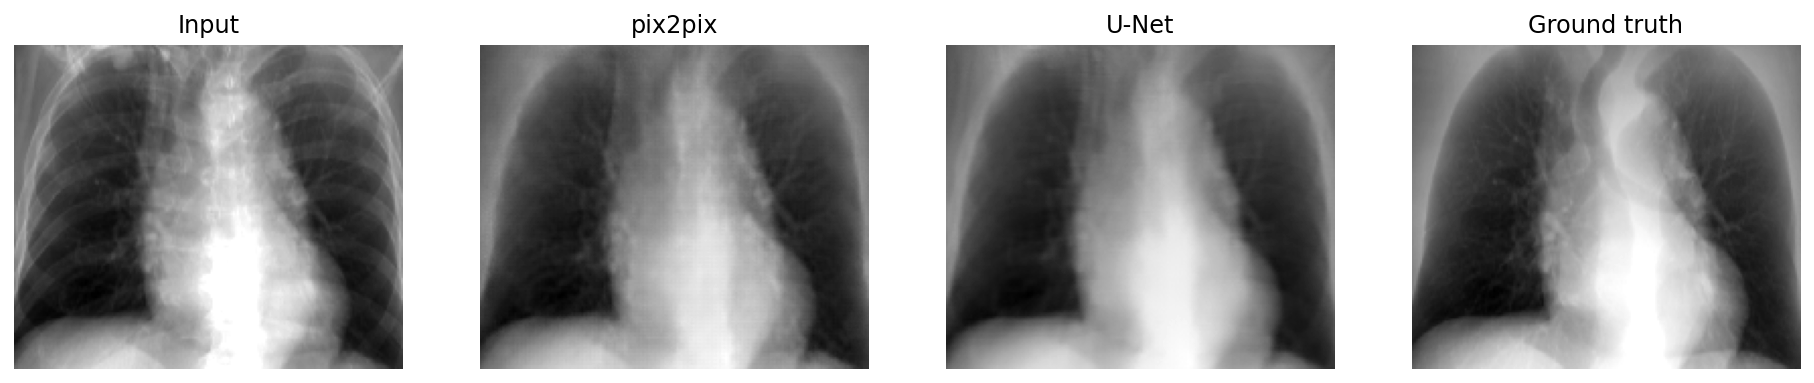

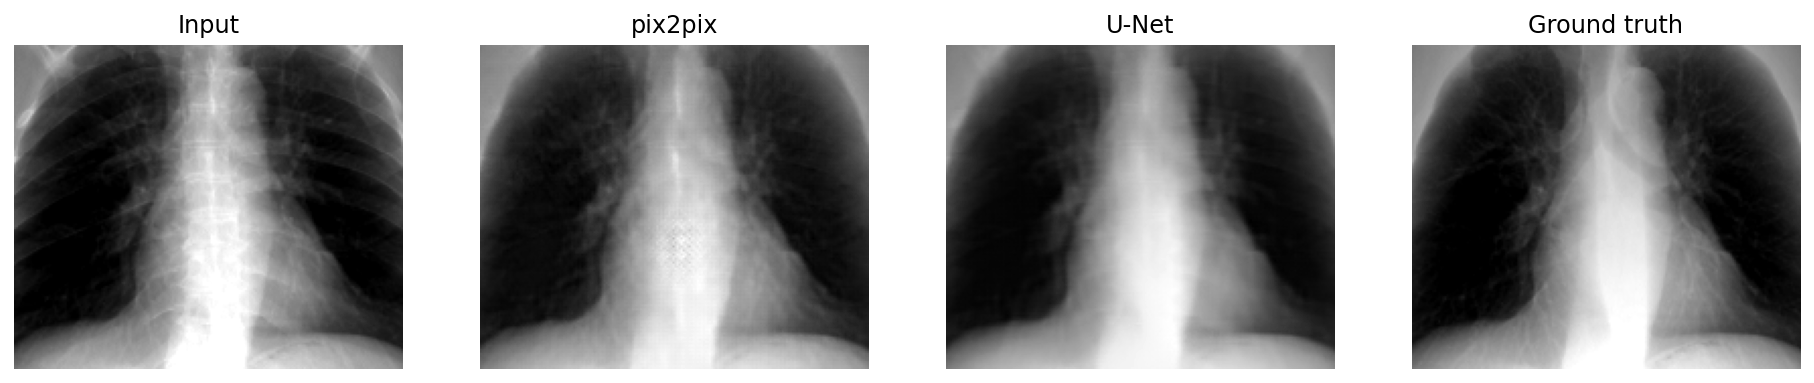

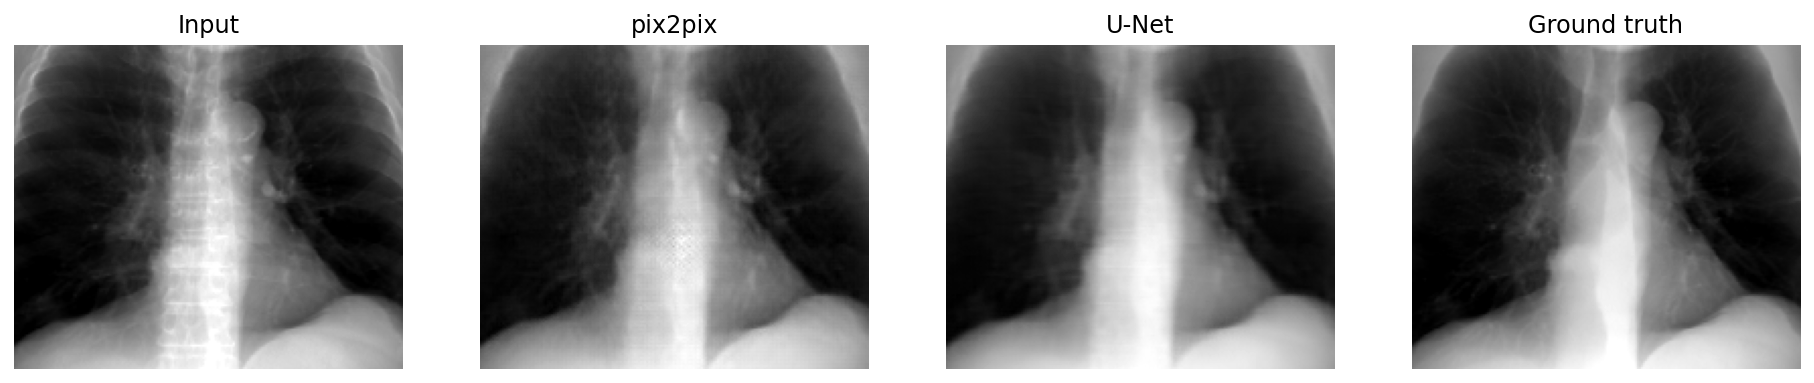

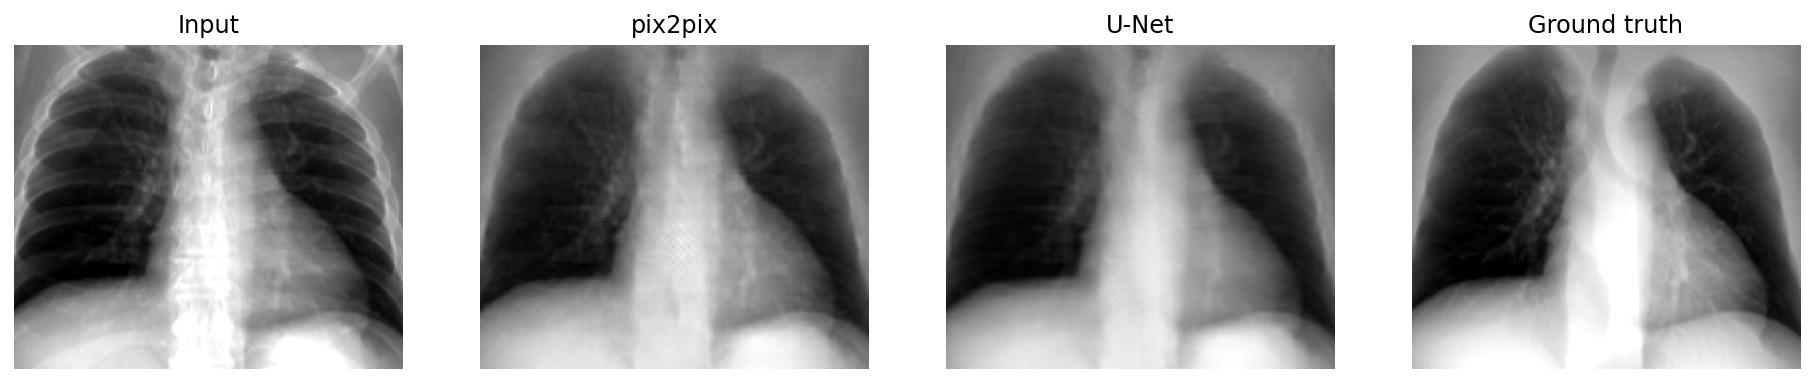

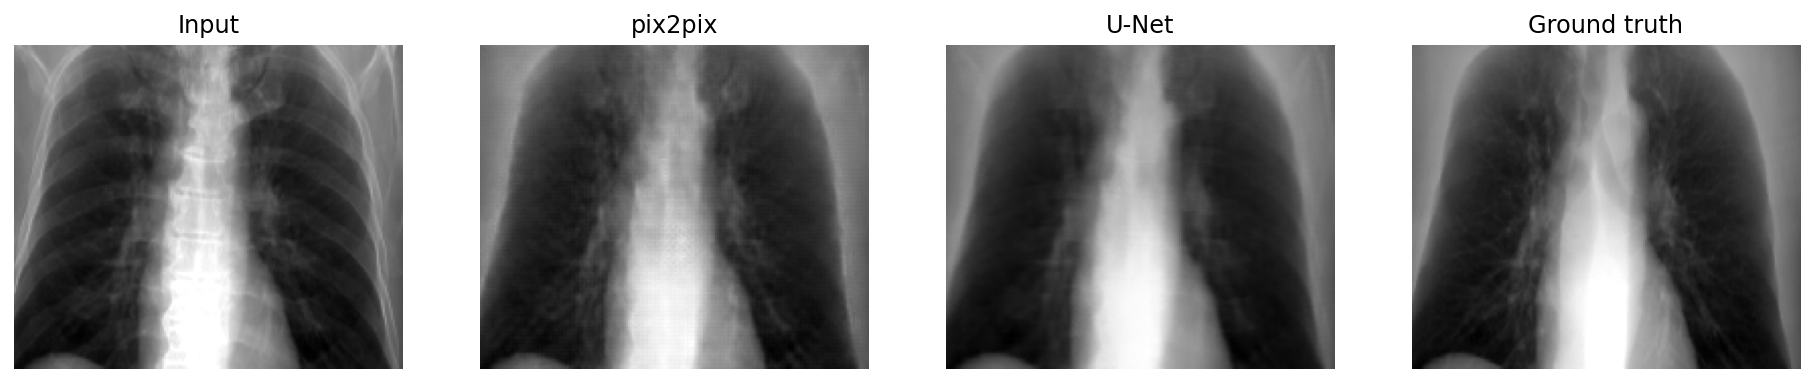

In [10]:
def crop_and_show(image):
    margin = 32
    plt.imshow(image[margin:-margin * 2, margin:-margin], cmap='gray')


for data, pix2pix, unet in zip(zip(*batch), pix2pix_prediction,
                               unet_prediction):
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 4, 1)
    crop_and_show(data[0].numpy().squeeze())
    plt.title('Input')
    plt.axis('off')
    plt.subplot(1, 4, 2)
    crop_and_show(pix2pix.squeeze())
    plt.title('pix2pix')
    plt.axis('off')
    plt.subplot(1, 4, 3)
    crop_and_show(unet.squeeze())
    plt.title('U-Net')
    plt.axis('off')
    plt.subplot(1, 4, 4)
    crop_and_show(data[1].numpy().squeeze())
    plt.title('Ground truth')
    plt.axis('off')
    plt.show()